In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn import model_selection
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import nltk.data

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [4]:
# read the dataset
reviews_data = pd.read_json(r"C:\Users\user\Documents\UoM\Thesis\data\Clothing_Shoes_and_Jewelry_5.json", lines=True)

# Keep only the review text and the grade
reviews_data = reviews_data[['overall', 'reviewText']]

# Drop the products whose values are null
reviews_data = reviews_data[reviews_data['reviewText'].notna()]

In [5]:
ratings = []
for index,entry in enumerate(reviews_data['overall']):
    if entry == 1.0 or entry == 2.0:
        ratings.append(-1)
    elif entry == 3.0:
        ratings.append(0)
    elif entry == 4.0 or entry == 5.0:
        ratings.append(1)

In [6]:
""""
Split each review into sentences
and preprocess each sentence
"""
stopwords = stopwords.words('english')

preprocessed_data = []
index = 0
for review in reviews_data['reviewText']:
    if(index % 10000 == 0):
        print(index)
    review_sentences = tokenizer.tokenize(review)
    for sentence in review_sentences:
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        sentence = sentence.lower()
        sentence = word_tokenize(sentence)
        sentence = [word for word in sentence if not word in stopwords]
        sentence = ' '.join(sentence)
        if(sentence != ''):
            review = {}
            review["index"] = index
            review["sentence"] = sentence
            review["rating"] = ratings[index]
            preprocessed_data.append(review)
    index += 1

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000


In [7]:
print("Before preprocessing: ", reviews_data['reviewText'][75945 ])
print("------------------------------------------------")
print("After preprocessing: ", [d for d in preprocessed_data if d['index'] == 75945 ])
print(len(preprocessed_data))

Before preprocessing:  These socks fall down past the heel.  Normally this brand is good, but these did not work out at all.
------------------------------------------------
After preprocessing:  [{'index': 75945, 'sentence': 'socks fall past heel', 'rating': -1}, {'index': 75945, 'sentence': 'normally brand good work', 'rating': -1}]
1172750


In [8]:
# Split Dataset into training and test
indexes = [i for i in range(len(reviews_data))]

Train_X_index, Test_X_index, Train_Y_review, Test_Y_review = model_selection.train_test_split(indexes,ratings,test_size=0.3,random_state=42)

df = pd.DataFrame(preprocessed_data)

train = df[df['index'].isin(Train_X_index)]
Train_Y = train['rating'].tolist()
Train_X = train['sentence'].tolist()
Train_index = train['index'].tolist()


test = df[df['index'].isin(Test_X_index)]
Test_Y = test['rating'].tolist()
Test_X = test['sentence'].tolist()
Test_index = test['index'].tolist()

all_sentences = Train_X + Test_X

In [9]:
len(df)

1172750

In [10]:
# Word Vectorization
        
Hashing_vect = HashingVectorizer(alternate_sign=False)
Hashing_vect.fit(all_sentences)
Train_X_Hashing = Hashing_vect.transform(Train_X)
Test_X_Hashing = Hashing_vect.transform(Test_X)

In [11]:
# Undersampling 
undersampling = RandomUnderSampler()
X_un, y_un = undersampling.fit_resample(Train_X_Hashing, Train_Y)

In [12]:
def find_Max_Element(scores):
    c = Counter(scores)
    negatives = c[-1]
    neutral = c[0]
    positives = c[1]
    
    if(scores[0] == -1):
        negatives += 1
    elif(scores[0] == 0):
        neutral += 1
    elif(scores[0] == 1):
        positives += 1
    
    if(scores[-1] == -1):
        negatives += 1
    elif(scores[-1] == 0):
        neutral += 1
    elif(scores[-1] == 1):
        positives += 1

    if(neutral == positives and neutral > negatives and positives > negatives):
        max_element = 1
    elif (neutral == negatives and neutral > positives and negatives > positives):
        max_element = -1
    elif (neutral == negatives and negatives == positives):
        max_element = 0
    elif (positives == negatives and positives > neutral and negatives > neutral) :
        max_element = 0
    else:
        max_element = max(set(scores), key = scores.count)
        
    return max_element
#     return  max(set(scores), key = scores.count)

-9
Accuracy:  72.36916083497816
-----------------------
              precision    recall  f1-score   support

    Negative       0.43      0.64      0.51      7997
     Neutral       0.23      0.43      0.30      9177
    Positive       0.94      0.77      0.85     66421

    accuracy                           0.72     83595
   macro avg       0.53      0.61      0.56     83595
weighted avg       0.81      0.72      0.76     83595



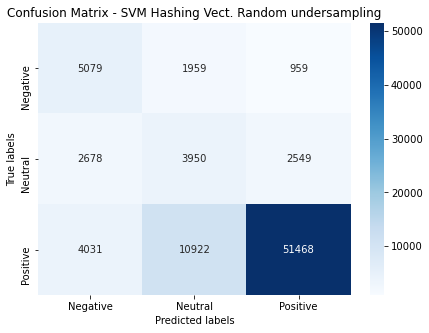

In [13]:
# Support Vector Machine with linear cernel
from sklearn.svm import LinearSVC

# Train the classifier
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_un, y_un)

predictions_SVM = clf.predict(Test_X_Hashing)

# Get grades by review
predicted_scores_frame = pd.DataFrame(np.column_stack([Test_index, predictions_SVM, Test_Y]), 
                               columns=['review Index', 'prediction', 'actual'])

print(len(predicted_scores_frame['review Index'].unique()) - len(Test_Y_review))

# for each review get all scores by review
scores_by_review_frame = predicted_scores_frame.groupby('review Index')['prediction'].apply(list)

majority_scores =  scores_by_review_frame.apply(find_Max_Element)
predicted_scores = list(majority_scores)

# for each review get its actual score
actual_scores_frame = predicted_scores_frame.groupby('review Index')['actual'].first()
actual_scores = list(actual_scores_frame)

# get all indexes
review_indexes = predicted_scores_frame['review Index'].unique()

# Calculate Accuracy
accuracy = accuracy_score(predicted_scores, actual_scores)*100
print("Accuracy: ", accuracy)
print("-----------------------")

# Confusion Matrix
cm = confusion_matrix(actual_scores, predicted_scores)
plt.figure(figsize = (7,5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',ax=ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - SVM Hashing Vect. Random undersampling'); 
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']);

# Classification Report
my_tags = ['Negative','Neutral','Positive']
print(classification_report(actual_scores, predicted_scores, target_names=my_tags))
report = classification_report(actual_scores, predicted_scores, target_names=my_tags, output_dict=True);
clsf_report = pd.DataFrame(report).transpose()
clsf_report.to_csv('reports/SVM_HashingVectorizer_Undersampling.csv', index= True)

In [14]:
# write indexes of false classified reviews to a txt file

data = {"review_index": review_indexes, "predict": predicted_scores, "actual": actual_scores}

review_dataframe = pd.DataFrame(data)

false_classified_indexes = review_dataframe['review_index'][review_dataframe['predict'] != review_dataframe['actual']]
false_classified_indexes = list(false_classified_indexes)

with open("indexes/SVM_HashingVectorizer_Undersampling.txt", 'w') as f:
    for item in false_classified_indexes:
        f.write("%s\n" % item)
        
# save those indexes who are predicted as negative but they are neutral
negativePredicted_neutralActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == -1) & (review_dataframe['actual'] == 0)]
negativePredicted_neutralActual_indexes = list(negativePredicted_neutralActual_indexes)
with open("indexes/SVM_HashingVectorizer_Undersampling_NegativePredicted_NeutralActual.txt", 'w') as f:
    for item in negativePredicted_neutralActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as negative but they are positive
negativePredicted_positiveActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == -1) & (review_dataframe['actual'] == 1)]
negativePredicted_positiveActual_indexes = list(negativePredicted_positiveActual_indexes)
with open("indexes/SVM_HashingVectorizer_Undersampling_NegativePredicted_PositiveActual.txt", 'w') as f:
    for item in negativePredicted_positiveActual_indexes:
        f.write("%s\n" % item)
        
# save those indexes who are predicted as neutral but they are negative
neutralPredicted_negativeActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == 0) & (review_dataframe['actual'] == -1)]
neutralPredicted_negativeActual_indexes = list(neutralPredicted_negativeActual_indexes)
with open("indexes/SVM_HashingVectorizer_Undersampling_NeutralPredicted_NegativeActual.txt", 'w') as f:
    for item in neutralPredicted_negativeActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as neutral but they are positive
neutralPredicted_positiveActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == 0) & (review_dataframe['actual'] == 1)]
neutralPredicted_positiveActual_indexes = list(neutralPredicted_positiveActual_indexes)
with open("indexes/SVM_HashingVectorizer_Undersampling_NeutralPredicted_PositiveActual.txt", 'w') as f:
    for item in neutralPredicted_positiveActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as positive but they are negative        
positivePredicted_negativeActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == 1) & (review_dataframe['actual'] == -1)]
positivePredicted_negativeActual_indexes = list(positivePredicted_negativeActual_indexes)
with open("indexes/SVM_HashingVectorizer_Undersampling_PositivePredicted_NegativeActual.txt", 'w') as f:
    for item in positivePredicted_negativeActual_indexes:
        f.write("%s\n" % item)
 
# save those indexes who are predicted as positive but they are neutral 
positivePredicted_neutralActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == 1) & (review_dataframe['actual'] == 0)]
positivePredicted_neutralActual_indexes = list(positivePredicted_neutralActual_indexes)
with open("indexes/SVM_HashingVectorizer_Undersampling_PositivePredicted_NeutralActual.txt", 'w') as f:
    for item in positivePredicted_neutralActual_indexes:
        f.write("%s\n" % item)
